Генерация слоя городских кварталов с помощью blocksnet

In [200]:
!pip install blocksnet  -q
!pip install blocksnet ipykernel mapclassify -qq


In [201]:
import geopandas as gpd
import osmnx as ox
import pandas as pd
import os


In [ ]:
data_path = "../data/scenario 2 - data"
results_path = "../results/scenario 2 - results"

<h3>Загрузка границ, дорог, построение полигонов</h3>

<Axes: >

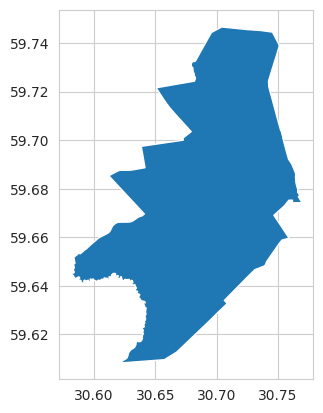

In [203]:
boundary = gpd.read_file(os.path.join(data_path,'boundary.geojson'))
boundary.plot()

<Axes: >

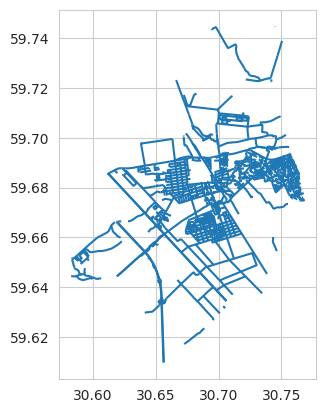

In [204]:
roads = gpd.read_file(os.path.join(data_path,'roads.geojson'))
roads.plot()

In [205]:
local_crs = boundary.estimate_utm_crs()
local_crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [206]:
boundary = boundary.reset_index()[['geometry']].to_crs(local_crs)
roads = roads.reset_index()[['geometry']].to_crs(local_crs)

In [207]:
import momepy

roads = roads[roads.geom_type.isin(['LineString', 'MultiLineString'])]
GAP_TOLERANCE = 1
def _get_roads(roads):
    merged = roads.unary_union
    if merged.geom_type == 'MultiLineString':
        roads = gpd.GeoDataFrame(geometry=list(merged.geoms), crs=roads.crs)
    else:
        roads = gpd.GeoDataFrame(geometry=[merged], crs=roads.crs)
    roads = roads.explode(index_parts=False).reset_index(drop=True)
    roads.geometry = momepy.close_gaps(roads, GAP_TOLERANCE)
    roads = roads[roads.geom_type.isin(['LineString'])]
    return roads

roads = _get_roads(roads)
roads

geometry
0     LINESTRING (365578.066 6618818.811, 365585.179...
1     LINESTRING (367700.433 6616376.542, 367698.837...
2     LINESTRING (368477.180 6617657.195, 368413.340...
3     LINESTRING (368413.340 6617725.792, 368382.078...
4     LINESTRING (372228.902 6619496.063, 372224.703...
...                                                 ...
2019  LINESTRING (370972.522 6616514.548, 370892.825...
2020  LINESTRING (370892.825 6616655.651, 370831.078...
2021  LINESTRING (370831.078 6616764.973, 370749.746...
2022  LINESTRING (369725.430 6616833.426, 369938.807...
2023  LINESTRING (370164.089 6616751.685, 370164.090...

[2024 rows x 1 columns]

In [208]:
from blocksnet import BlocksGenerator

bg = BlocksGenerator(boundary, roads, None, None)

2024-12-24 18:31:53.064 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:99 - Check boundaries schema
2024-12-24 18:31:53.114 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:103 - Check roads schema
2024-12-24 18:31:53.176 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:109 - Check railways schema
2024-12-24 18:31:53.194 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:115 - Check water schema
2024-12-24 18:31:53.203 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:124 - Exclude water objects


In [209]:
blocks = bg.run()
blocks

2024-12-24 18:31:53.275 | INFO     | blocksnet.preprocessing.blocks_generator:run:161 - Generating blocks
2024-12-24 18:31:53.345 | INFO     | blocksnet.preprocessing.blocks_generator:run:170 - Setting up enclosures
2024-12-24 18:31:53.678 | INFO     | blocksnet.preprocessing.blocks_generator:run:174 - Filling holes
2024-12-24 18:31:53.836 | INFO     | blocksnet.preprocessing.blocks_generator:run:178 - Dropping overlapping blocks
2024-12-24 18:31:54.020 | INFO     | blocksnet.preprocessing.blocks_generator:run:192 - Calculating blocks area
2024-12-24 18:31:54.048 | INFO     | blocksnet.preprocessing.blocks_generator:run:199 - Blocks generated


geometry
0    POLYGON ((365578.066 6618818.811, 365585.179 6...
1    POLYGON ((365585.179 6618823.682, 365578.066 6...
2    POLYGON ((367700.433 6616376.542, 367698.837 6...
3    POLYGON ((367699.528 6616357.359, 367698.808 6...
4    POLYGON ((368477.180 6617657.195, 368413.340 6...
..                                                 ...
435  POLYGON ((370476.006 6616117.540, 370376.801 6...
436  POLYGON ((370570.270 6616143.039, 370476.006 6...
437  POLYGON ((369763.595 6616412.682, 369751.136 6...
438  POLYGON ((369951.525 6616791.491, 369938.807 6...
439  POLYGON ((369964.117 6616725.721, 369951.525 6...

[440 rows x 1 columns]

<Axes: >

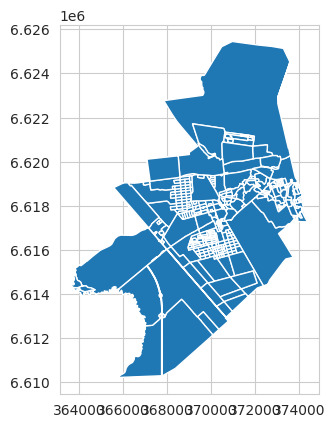

In [210]:
blocks.plot()

In [211]:
blocks.to_file(os.path.join(results_path,'blocks_blocksnet_1.geojson'))

### Свои дороги

In [212]:
CRS = 32636
SPEED_M_MIN = 1000

import networkx as nx

def _roads_to_graph(roads):
    graph = momepy.gdf_to_nx(roads)
    graph.graph['crs'] = roads.crs.to_epsg()
    graph = nx.DiGraph(graph)
    for _, _, data in graph.edges(data=True):
        geometry = data['geometry']
        data['time_min'] = geometry.length / SPEED_M_MIN
        # data['weight'] = data['mm_len'] / 1000 / 1000
        # data['length_meter'] = data['mm_len'] / 1000
    for n, data in graph.nodes(data=True):
        graph.nodes[n]['x'] = n[0]  # Assign X coordinate to node
        graph.nodes[n]['y'] = n[1]

    return graph

roads_G = _roads_to_graph(roads)
roads_G

In [213]:
from blocksnet import AccessibilityProcessor
AccessibilityProcessor._fix_graph(roads_G)

In [214]:
from blocksnet import AccessibilityProcessor

ap = AccessibilityProcessor(blocks)
acc_mx = ap.get_accessibility_matrix(roads_G)
acc_mx.head() # вывод первых 5 строк полученной матрицы

0         1         2         3         4         5         6    \
0  0.000000  1.937500  2.962891  3.136719  4.253906  4.492188  7.527344   
1  1.937500  0.000000  4.308594  4.472656  2.791016  3.458984  5.609375   
2  2.962891  4.308594  0.000000  0.175293  1.666992  1.792969  6.339844   
3  3.136719  4.472656  0.175293  0.000000  1.831055  1.957031  6.503906   
4  4.253906  2.791016  1.666992  1.831055  0.000000  0.819336  5.011719   

        7         8         9    ...       430       431       432       433  \
0  7.738281  7.386719  7.691406  ...  6.468750  6.632812  6.566406  6.664062   
1  5.820312  5.468750  5.773438  ...  5.996094  5.699219  5.949219  5.851562   
2  6.269531  6.011719  5.683594  ...  3.505859  3.669922  3.605469  3.701172   
3  6.433594  6.175781  5.847656  ...  3.332031  3.494141  3.429688  3.525391   
4  4.941406  4.683594  4.355469  ...  3.548828  3.251953  3.500000  3.404297   

        434       435       436       437       438       439  
0  6.535156  6.628906  6.726562  5.804688  6.535156  6.738281  
1  5.601562  5.699219  5.796875  4.871094  5.605469  5.804688  
2  3.572266  3.667969  3.765625  2.841797  3.574219  3.775391  
3  3.398438  3.494141  3.591797  2.667969  3.398438  3.599609  
4  3.156250  3.251953  3.349609  2.425781  3.156250  3.357422  

[5 rows x 440 columns]

In [215]:
from blocksnet.models import City
from blocksnet import Accessibility, Connectivity

blocks['land_use'] = None

city = City(
    blocks=blocks,
    acc_mx=acc_mx
)

connectivity = Connectivity(city_model=city)
connectivity_result = connectivity.calculate()
connectivity_result

geometry  connectivity
id                                                                  
0    POLYGON ((365578.066 6618818.811, 365585.179 6...      6.335938
1    POLYGON ((365585.179 6618823.682, 365578.066 6...      5.265625
2    POLYGON ((367700.433 6616376.542, 367698.837 6...      3.566406
3    POLYGON ((367699.528 6616357.359, 367698.808 6...      3.437500
4    POLYGON ((368477.180 6617657.195, 368413.340 6...      3.072266
..                                                 ...           ...
435  POLYGON ((370476.006 6616117.540, 370376.801 6...      2.960938
436  POLYGON ((370570.270 6616143.039, 370476.006 6...      2.988281
437  POLYGON ((369763.595 6616412.682, 369751.136 6...      2.820312
438  POLYGON ((369951.525 6616791.491, 369938.807 6...      3.236328
439  POLYGON ((369964.117 6616725.721, 369951.525 6...      3.439453

[440 rows x 2 columns]

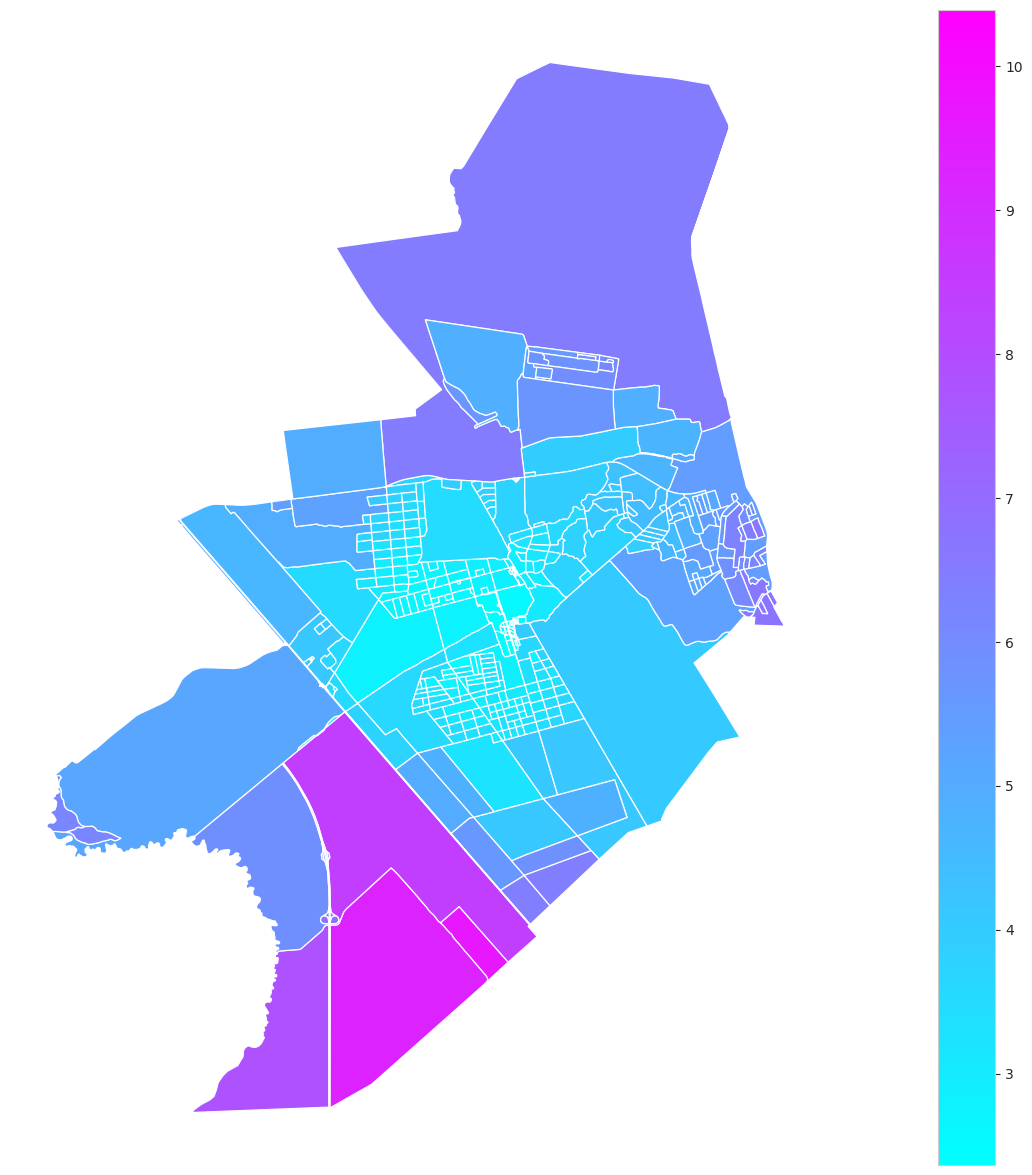

In [216]:
Connectivity.plot(connectivity_result, linewidth=0.9, figsize=(30,15))

In [217]:
import os
acc_mx.to_pickle(os.path.join(results_path,'acc_mx_1.pickle'))
city.to_pickle(os.path.join(results_path,'city_model_scenario 1.pickle'))

----

###Загрузка зданий

In [218]:
buildings = gpd.read_file(os.path.join(data_path,'buildings.geojson'))
buildings.explore()

In [219]:
buildings = buildings.to_crs(local_crs) # переводим здания в локальную систему координат
buildings.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [220]:
buildings

population building:levels  is_living      type  id  living_area  \
0            105               1          1      None NaN       9415.0   
1            181               1          1      None NaN      16129.0   
2            266               1          1      None NaN      23760.0   
3            207               1          1      None NaN      18483.0   
4            257               1          1      None NaN      22990.0   
...          ...             ...        ...       ...  ..          ...   
4858           0               1          0  building NaN          NaN   
4859           0               1          1  building NaN        106.0   
4860           0               1          1  building NaN        106.0   
4861           0               1          1  building NaN        103.0   
4862           0               1          1  building NaN         47.0   

         building                                           geometry  
0     residential  MULTIPOLYGON (((370275.310 6615610.185, 370187...  
1     residential  MULTIPOLYGON (((370187.349 6615735.386, 370275...  
2     residential  MULTIPOLYGON (((370187.349 6615735.386, 370128...  
3     residential  MULTIPOLYGON (((370069.245 6615903.491, 369943...  
4     residential  MULTIPOLYGON (((369943.208 6616082.889, 369850...  
...           ...                                                ...  
4858         None  MULTIPOLYGON (((371083.463 6616832.478, 371105...  
4859  residential  MULTIPOLYGON (((370660.184 6617353.896, 370660...  
4860  residential  MULTIPOLYGON (((370646.427 6617582.335, 370651...  
4861  residential  MULTIPOLYGON (((370591.537 6617578.189, 370596...  
4862  residential  MULTIPOLYGON (((367248.292 6618852.769, 367248...  

[4863 rows x 8 columns]

In [221]:
buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]
buildings.head()

population building:levels  is_living  type  id  living_area     building  \
0         105               1          1  None NaN       9415.0  residential   
1         181               1          1  None NaN      16129.0  residential   
2         266               1          1  None NaN      23760.0  residential   
3         207               1          1  None NaN      18483.0  residential   
4         257               1          1  None NaN      22990.0  residential   

                                            geometry  
0  MULTIPOLYGON (((370275.310 6615610.185, 370187...  
1  MULTIPOLYGON (((370187.349 6615735.386, 370275...  
2  MULTIPOLYGON (((370187.349 6615735.386, 370128...  
3  MULTIPOLYGON (((370069.245 6615903.491, 369943...  
4  MULTIPOLYGON (((369943.208 6616082.889, 369850...

In [222]:
# Сброс индекса, чтобы превратить индексы в обычные столбцы
buildings = buildings.reset_index(drop=True)
# Проверяем результат
buildings.head()

population building:levels  is_living  type  id  living_area     building  \
0         105               1          1  None NaN       9415.0  residential   
1         181               1          1  None NaN      16129.0  residential   
2         266               1          1  None NaN      23760.0  residential   
3         207               1          1  None NaN      18483.0  residential   
4         257               1          1  None NaN      22990.0  residential   

                                            geometry  
0  MULTIPOLYGON (((370275.310 6615610.185, 370187...  
1  MULTIPOLYGON (((370187.349 6615735.386, 370275...  
2  MULTIPOLYGON (((370187.349 6615735.386, 370128...  
3  MULTIPOLYGON (((370069.245 6615903.491, 369943...  
4  MULTIPOLYGON (((369943.208 6616082.889, 369850...

In [223]:
# Преобразуем столбец 'building:levels' в числовой тип, ошибки будут заменены на NaN
buildings['building:levels'] = pd.to_numeric(buildings['building:levels'], errors='coerce')

# Заполним пропущенные значения (NaN) нулями или другими подходящими значениями
buildings = buildings.fillna(0)

# Добавляем или преобразуем необходимые атрибуты

# 1. Количество этажей (number_of_floors)
buildings['number_of_floors'] = buildings.apply(
    lambda x: x['building:levels'] if x['building:levels'] > 1 else 1,
    axis=1
)

# 2. Площадь застройки (footprint_area) - как площадь геометрии (основание здания)
buildings['footprint_area'] = buildings.geometry.area

# 3. Общая площадь всех этажей (build_floor_area) - footprint_area * number_of_floors
buildings['build_floor_area'] = buildings['footprint_area'] * buildings['number_of_floors']

# 4. Жилая площадь (living_area) и нежилая площадь (non_living_area)
# Жилая площадь будет рассчитываться только для жилых зданий
residential_tags = ['residential', 'house', 'apartments', 'detached', 'terrace', 'dormitory', 'yes']
buildings['living_area'] = buildings.apply(
    lambda x: 0.8 * x['build_floor_area'] if x['building'] in residential_tags else 0,
    axis=1
)

# Нежилая площадь будет 20% от общей площади этажей
buildings['non_living_area'] = buildings['build_floor_area'] - buildings['living_area']

# 5. Население (population) - для жилых зданий
buildings['population'] = buildings.apply(
    lambda x: 48 * x['number_of_floors'] if x['building'] in residential_tags else 0,
    axis=1
)

# Теперь удалим все остальные столбцы, кроме 'geometry', 'build_floor_area', 'living_area', 'non_living_area',
# 'footprint_area', 'number_of_floors', 'population'
buildings = buildings[['geometry', 'build_floor_area', 'living_area', 'non_living_area',
                       'footprint_area', 'number_of_floors', 'population']]

# Проверим результат
buildings


geometry  build_floor_area  \
0     MULTIPOLYGON (((370275.310 6615610.185, 370187...       9411.402102   
1     MULTIPOLYGON (((370187.349 6615735.386, 370275...      16123.206996   
2     MULTIPOLYGON (((370187.349 6615735.386, 370128...      23750.692171   
3     MULTIPOLYGON (((370069.245 6615903.491, 369943...      18476.192337   
4     MULTIPOLYGON (((369943.208 6616082.889, 369850...      22981.621797   
...                                                 ...               ...   
4858  MULTIPOLYGON (((371083.463 6616832.478, 371105...        525.565495   
4859  MULTIPOLYGON (((370660.184 6617353.896, 370660...        105.650230   
4860  MULTIPOLYGON (((370646.427 6617582.335, 370651...        106.014300   
4861  MULTIPOLYGON (((370591.537 6617578.189, 370596...        103.229590   
4862  MULTIPOLYGON (((367248.292 6618852.769, 367248...         47.247866   

       living_area  non_living_area  footprint_area  number_of_floors  \
0      7529.121682      1882.280420     9411.402102                 1   
1     12898.565597      3224.641399    16123.206996                 1   
2     19000.553736      4750.138434    23750.692171                 1   
3     14780.953870      3695.238467    18476.192337                 1   
4     18385.297437      4596.324359    22981.621797                 1   
...            ...              ...             ...               ...   
4858      0.000000       525.565495      525.565495                 1   
4859     84.520184        21.130046      105.650230                 1   
4860     84.811440        21.202860      106.014300                 1   
4861     82.583672        20.645918      103.229590                 1   
4862     37.798293         9.449573       47.247866                 1   

      population  
0             48  
1             48  
2             48  
3             48  
4             48  
...          ...  
4858           0  
4859          48  
4860          48  
4861          48  
4862          48  

[4863 rows x 7 columns]

In [224]:
city.update_buildings(buildings)

2024-12-24 18:32:07.912 | INFO     | blocksnet.models.city:update_buildings:1237 - Removing existing blocks from the model
2024-12-24 18:32:07.917 | INFO     | blocksnet.models.city:update_buildings:1241 - Joining buildings and blocks
Update blocks buildings: 100%|██████████| 319/319 [00:04<00:00, 71.05it/s] 


Empty GeoDataFrame
Columns: [geometry, build_floor_area, living_area, non_living_area, footprint_area, number_of_floors, population]
Index: []

In [225]:
city.to_pickle(os.path.join('city_model.pickle'))

<Axes: >

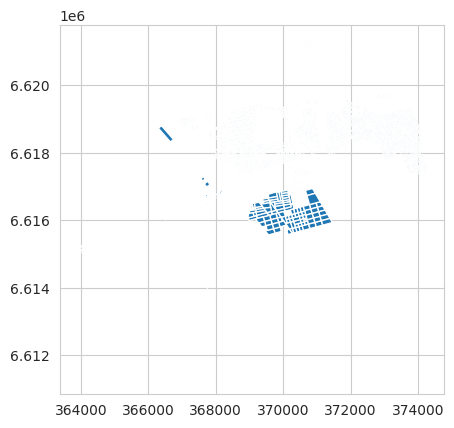

In [226]:
city.get_buildings_gdf().plot()

---------

###Загрузка сервисов

In [227]:
import os
import geopandas as gpd
from shapely.geometry import Point
from blocksnet import ServiceType

directory = os.fsencode(f"{data_path}/servises/")
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".geojson"):
        service_name = filename.removesuffix(".geojson")
        print(f"Adding service {service_name}")
        service_gdf = gpd.read_file(f"{data_path}/servises/" + filename)
        service_gdf.to_crs(local_crs, inplace=True)
        service = service_gdf[["geometry"]]
        try:
          city.update_services(service_name, service)
        except:
          continue
    else:
        continue

Adding service school
Adding service bus_station
Adding service supermarket
Adding service kindergarten


In [228]:
services_gdf = city.get_services_gdf()
services_gdf

geometry  block_id  service_type  capacity   area  \
0   POINT (367125.658 6619108.228)         1   bus_station        70  150.0   
1   POINT (372335.322 6619423.558)         7   bus_station        70  150.0   
2   POINT (373175.428 6619226.282)        25   bus_station        70  150.0   
3   POINT (373138.560 6619232.616)        26   bus_station        70  150.0   
4   POINT (373677.597 6619394.496)        26   bus_station        70  150.0   
..                             ...       ...           ...       ...    ...   
85  POINT (370126.280 6616077.412)       426   supermarket       200  100.0   
86  POINT (370155.844 6615978.702)       428   supermarket       200  100.0   
87  POINT (370423.691 6615947.678)       430   supermarket       200  100.0   
88  POINT (370310.125 6616142.925)       434  kindergarten        80  180.0   
89  POINT (370057.215 6616771.820)       439   supermarket       200  100.0   

    is_integrated  building_id  
0           False          NaN  
1           False          NaN  
2           False          NaN  
3           False          NaN  
4           False          NaN  
..            ...          ...  
85           True         25.0  
86           True         19.0  
87           True         21.0  
88           True         27.0  
89           True         87.0  

[90 rows x 7 columns]

---------------

###Подсчёт обеспеченности

Bus stantion

2024-12-24 18:32:21.922 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 60 : 285x35
2024-12-24 18:32:24.675 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-12-24 18:32:25.867 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-12-24 18:32:27.465 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


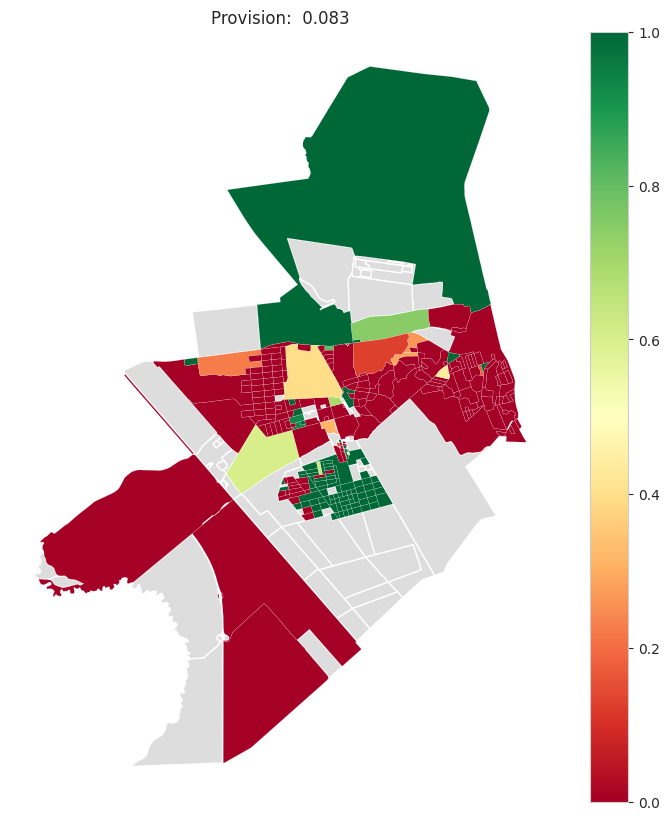

In [229]:
from blocksnet import Provision, ProvisionMethod
service_type = 'bus_station'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)
prov.plot(prov_res)

2024-12-24 18:32:31.657 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 7 : 285x12
2024-12-24 18:32:32.181 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-12-24 18:32:32.417 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-12-24 18:32:32.728 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


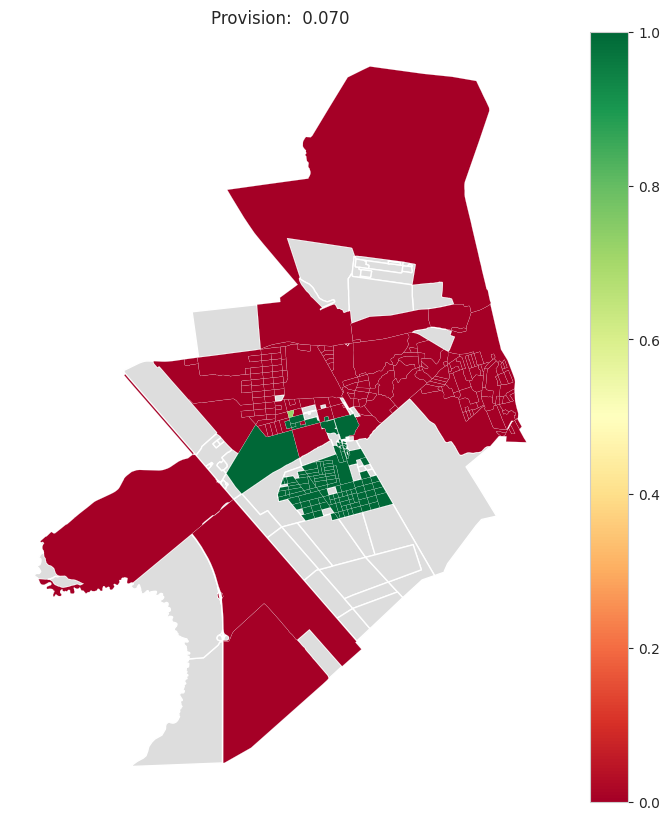

In [230]:
from blocksnet import Provision, ProvisionMethod
service_type = 'kindergarten'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)
prov.plot(prov_res)

2024-12-24 18:32:34.500 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 15 : 285x7
2024-12-24 18:32:34.949 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-12-24 18:32:35.131 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-12-24 18:32:35.595 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


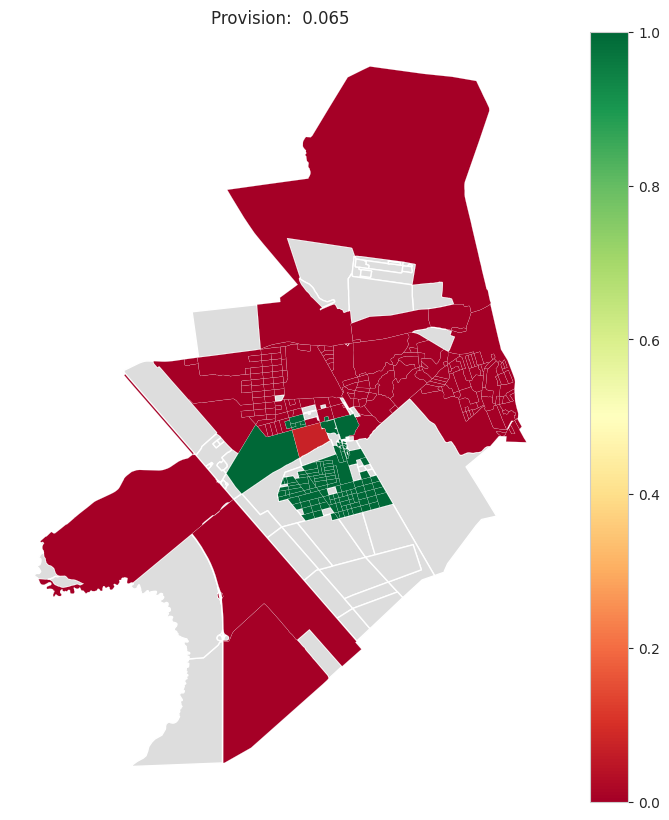

In [231]:
from blocksnet import Provision, ProvisionMethod
service_type = 'school'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)
prov.plot(prov_res)

2024-12-24 18:32:37.192 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 15 : 285x29
2024-12-24 18:32:38.376 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-12-24 18:32:39.140 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-12-24 18:32:39.764 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


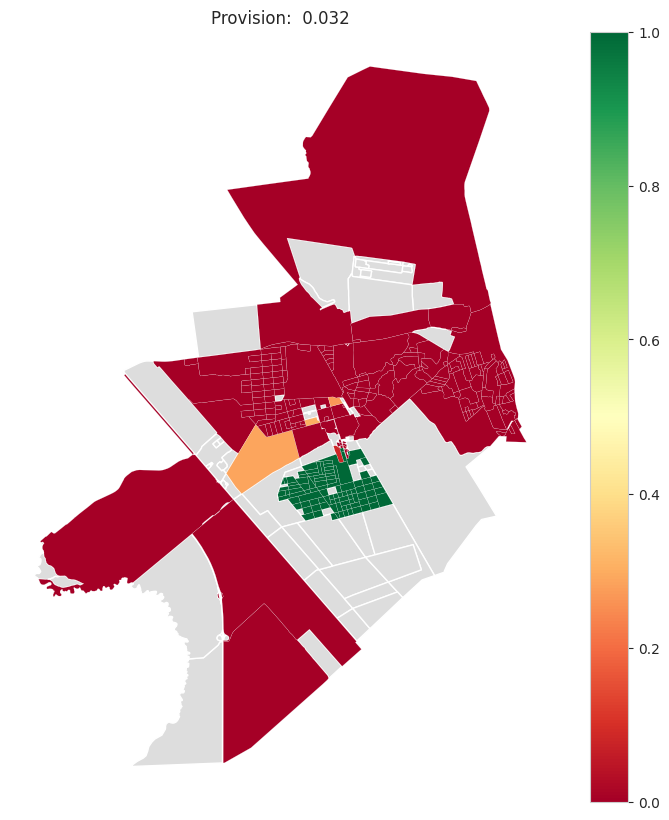

In [232]:
from blocksnet import Provision, ProvisionMethod
service_type = 'supermarket'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)
prov.plot(prov_res)

-------

###Оценка центральности по транспортной связности и разнообразию сервисов в кварталах

In [233]:
from blocksnet import Centrality, PopulationCentrality

In [234]:
centrality = Centrality(city_model=city)
result_centrality = centrality.calculate()
result_centrality

geometry  connectivity  \
id                                                                     
0    POLYGON ((365578.066 6618818.811, 365585.179 6...      6.335938   
1    POLYGON ((365585.179 6618823.682, 365578.066 6...      5.265625   
2    POLYGON ((367700.433 6616376.542, 367698.837 6...      3.566406   
3    POLYGON ((367699.528 6616357.359, 367698.808 6...      3.437500   
4    POLYGON ((368477.180 6617657.195, 368413.340 6...      3.072266   
..                                                 ...           ...   
435  POLYGON ((370476.006 6616117.540, 370376.801 6...      2.960938   
436  POLYGON ((370570.270 6616143.039, 370476.006 6...      2.988281   
437  POLYGON ((369763.595 6616412.682, 369751.136 6...      2.820312   
438  POLYGON ((369951.525 6616791.491, 369938.807 6...      3.236328   
439  POLYGON ((369964.117 6616725.721, 369951.525 6...      3.439453   

      density  diversity  centrality  
id                                    
0         NaN        NaN         NaN  
1    0.000030       -0.0    0.146537  
2         NaN        NaN         NaN  
3         NaN        NaN         NaN  
4         NaN        NaN         NaN  
..        ...        ...         ...  
435       NaN        NaN         NaN  
436       NaN        NaN         NaN  
437       NaN        NaN         NaN  
438       NaN        NaN         NaN  
439  0.000074       -0.0    0.108827  

[440 rows x 5 columns]

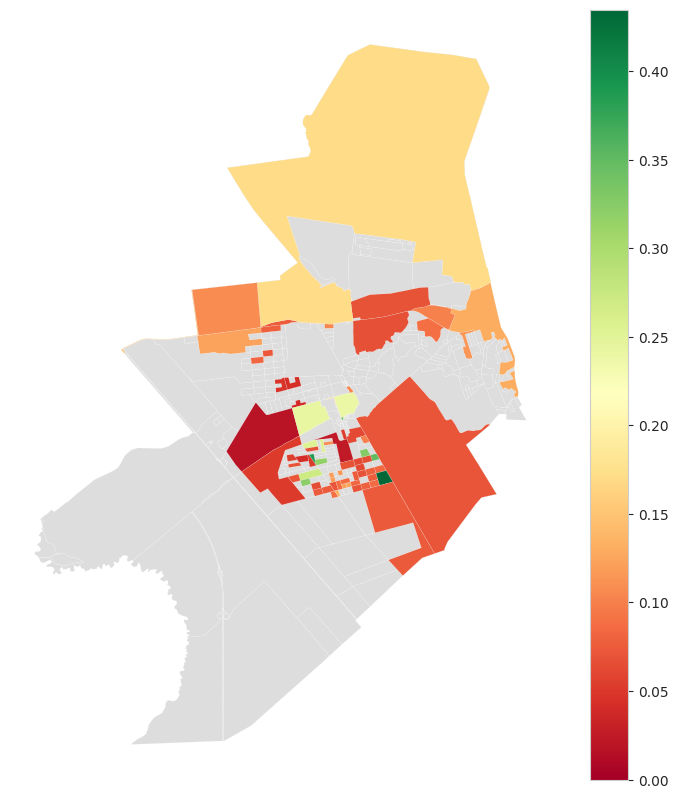

In [235]:
Centrality.plot(result_centrality, figsize =(10,10))

###Оценка центральности по транспортной связности и населению в квартала

In [236]:
centrality_population = PopulationCentrality(city_model=city)
result_centrlity_population = centrality_population.calculate()
result_centrlity_population

geometry  population_centrality
id                                                                           
0    POLYGON ((365578.066 6618818.811, 365585.179 6...                   0.05
1    POLYGON ((365585.179 6618823.682, 365578.066 6...                    NaN
2    POLYGON ((367700.433 6616376.542, 367698.837 6...                   1.39
3    POLYGON ((367699.528 6616357.359, 367698.808 6...                   1.24
4    POLYGON ((368477.180 6617657.195, 368413.340 6...                   3.02
..                                                 ...                    ...
435  POLYGON ((370476.006 6616117.540, 370376.801 6...                   4.87
436  POLYGON ((370570.270 6616143.039, 370476.006 6...                   4.77
437  POLYGON ((369763.595 6616412.682, 369751.136 6...                   5.92
438  POLYGON ((369951.525 6616791.491, 369938.807 6...                   5.72
439  POLYGON ((369964.117 6616725.721, 369951.525 6...                   5.92

[446 rows x 2 columns]

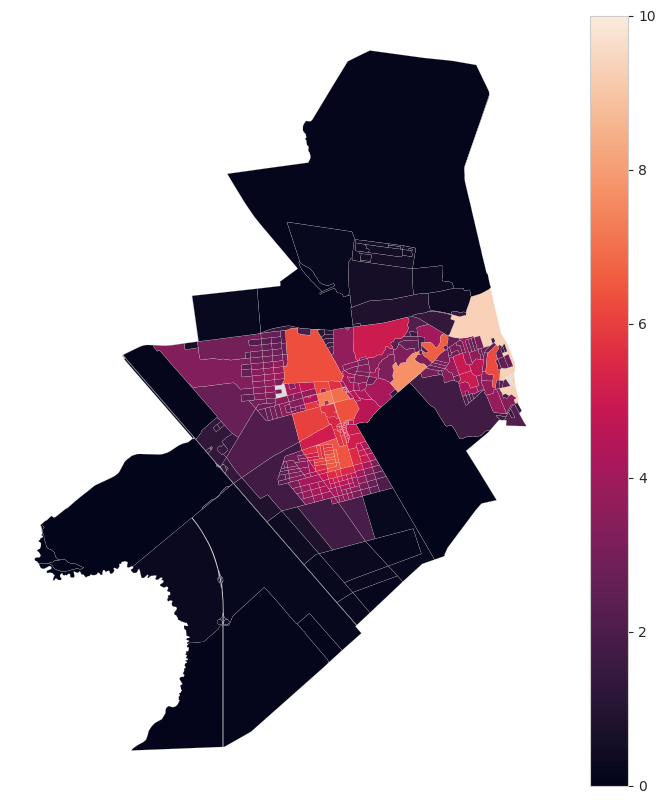

In [237]:
PopulationCentrality.plot(result_centrlity_population, figsize =(10,10))

-----------------------

### Доступность

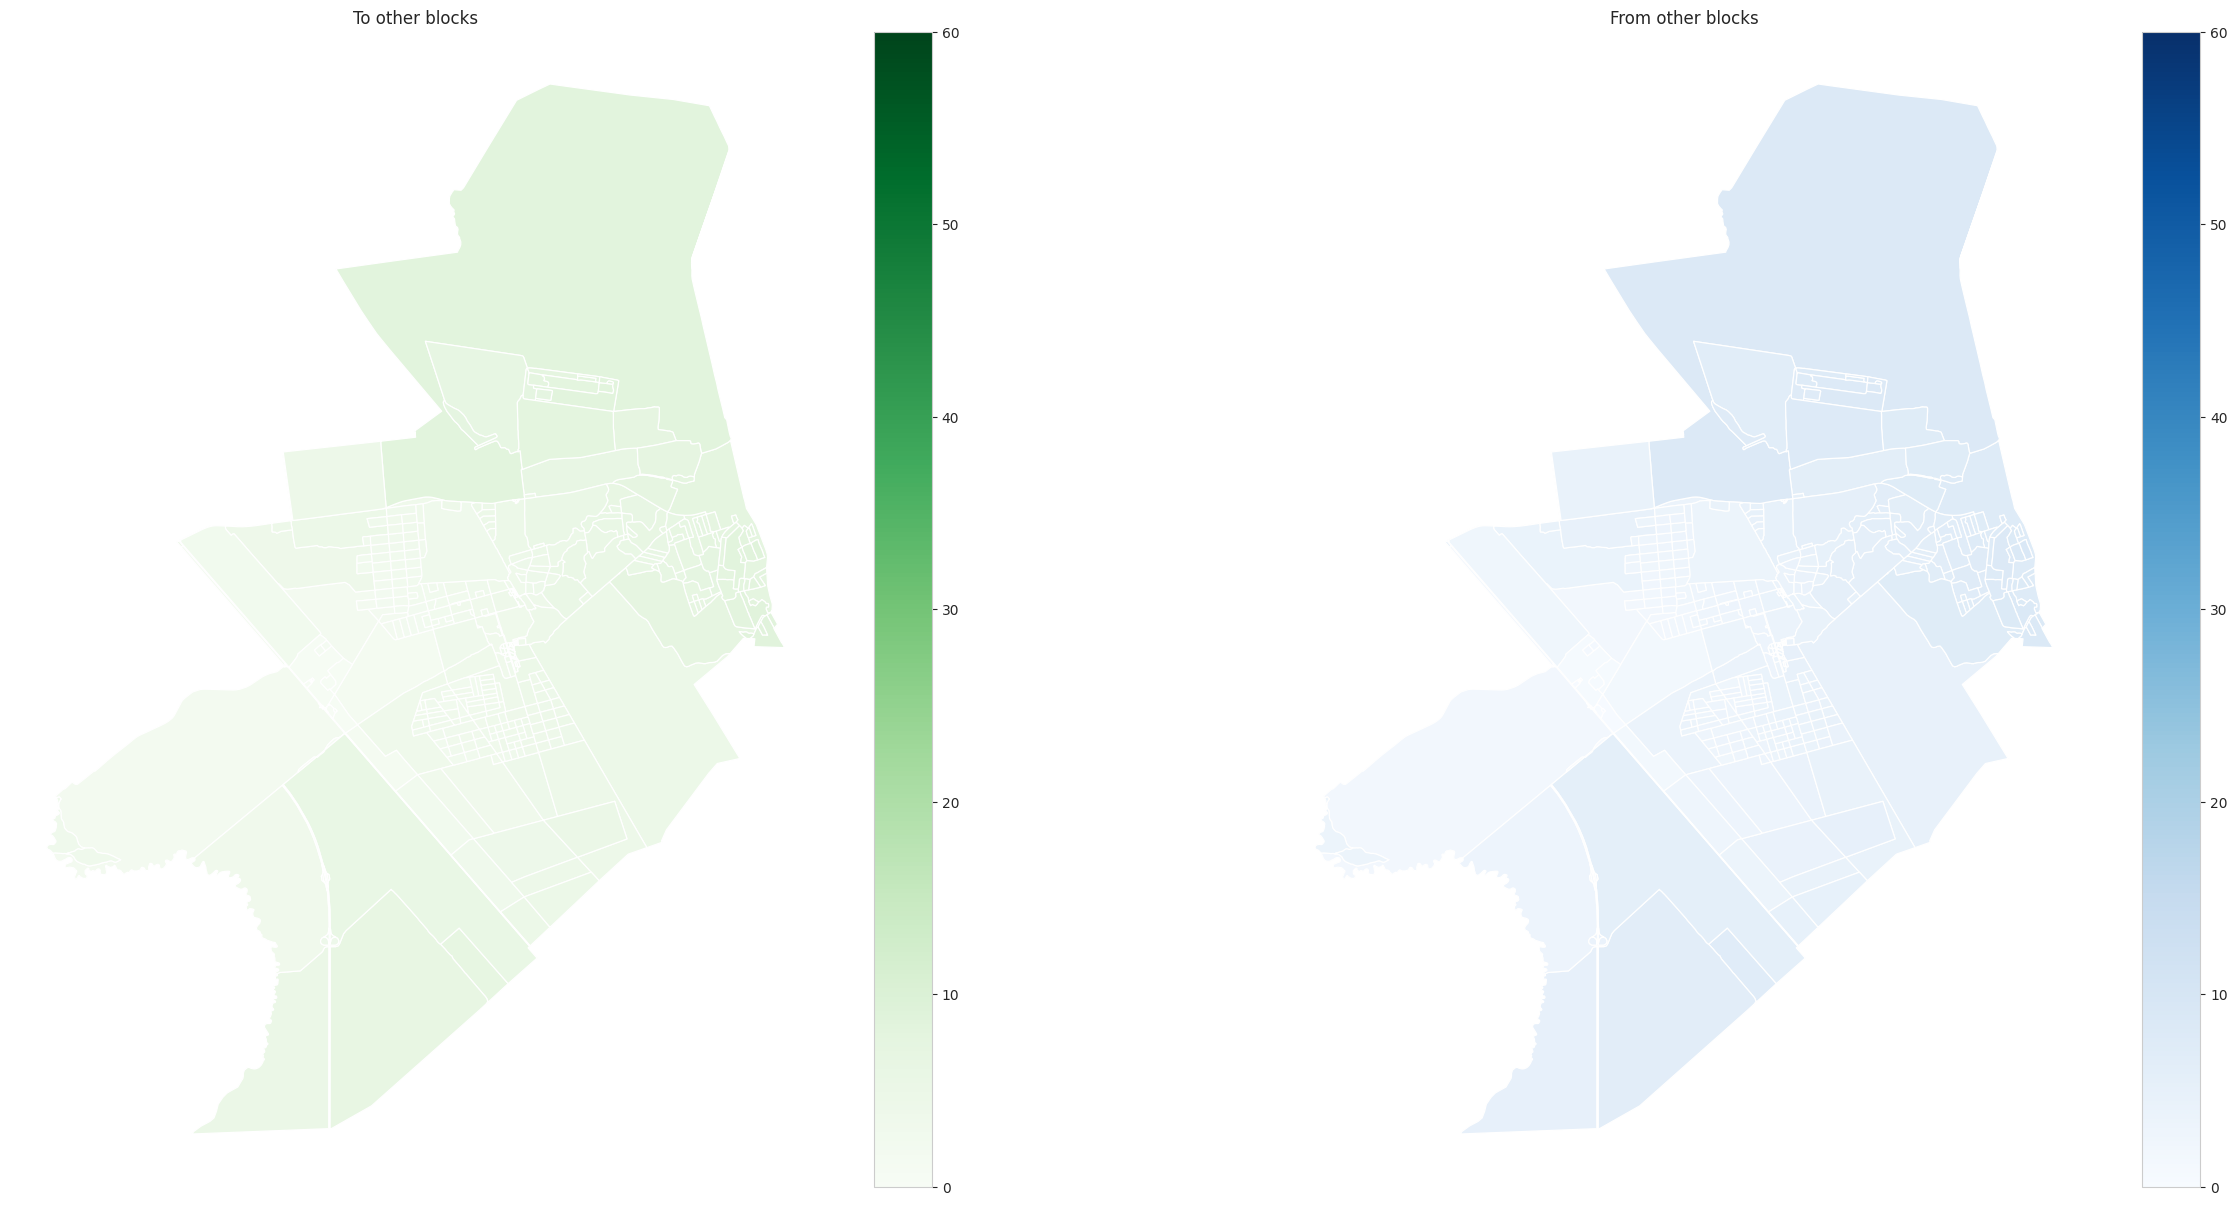

In [238]:
from blocksnet import Accessibility, Connectivity
accessibility = Accessibility(city_model=city)
block = city[2] # квартал от которого будем считать доступность
result = accessibility.calculate(block)

Accessibility.plot(result, linewidth=0.9, figsize=(30,15))

In [239]:
city.to_pickle(os.path.join(results_path,'city_model_scenario 1.pickle'))